This notebook is me taking notes on Maximum Likelihood Estimation (MLE), following the notes in the Reliability python package [docs](https://reliability.readthedocs.io/en/latest/How%20does%20Maximum%20Likelihood%20Estimation%20work.html).

MLE
---
MLE algorithm:
1) Obtain initial guess for model parameters
2) calculate probability of occurence of each data point
3) Multiply the probabilities - or, sum the logarithms, which is more computational efficient (also, see concept of log likelihood)
4) Optimize model parameters, repeating steps 2 and 3 as needed

Different types of data are handled differently...
| Type of Observation | Likelihood Function |
| --- | --- |
| Failure data | $L_i(\theta\|t_i)=f(t_i\|\theta)$ |
| Right censored data | $L_i(\theta\|t_i)=R(t_i\|\theta)$ |
| Left censored data | $L_i(\theta\|t_i)=F(t_i\|\theta)$ |
| Interval censored data | $L_i(\theta\|t_i) = F(t_i^{RI}\|\theta) - F(t_i^{LI}\|\theta)$ |

In the above, $f$ refers to the Probability Distribution Function (PDF), $F$ refers to the Cumulative Distribution Function (CDF), and $R$ refers to the survival function (SF, which is also the complement of the CDF, or 1-F).

MLE is typically used to fit distribution parameters (assuming a certain form of distribution) given the data points. The likelihood of those parameters, given the data, is as follows:
\begin{split}
L(\theta|D) = \prod_{i=1}^{n} L_i(\theta|t_i)
\end{split}

To avoid precision loss due to small values and save computation time, we can take the log:
\begin{split}
\ln(L(\theta|D)) = \sum_{i=1}^{n} \ln (L_i(\theta|t_i))
\end{split}

Example: Exponential Distribution
---

In [506]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [507]:
# Example: LL for exp distribution
t = np.array([27, 64, 3, 18, 8])

exp_pdf = lambda l, x: l * np.exp(-l * x)
exp_log_pdf = lambda l, x: np.log(l) - l * x

lam = 0.1
LL = np.sum(exp_log_pdf(lam, t))
print(LL)

-23.51292546497023


The value of lambda that maximizes the log likelihood is 0.04132
Note this value is not exact due to usage of np.argmax


Text(0, 0.5, 'LL')

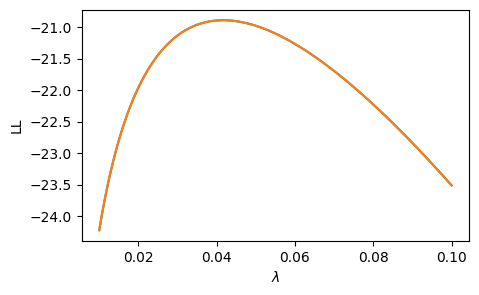

In [508]:
# Visualize how the LL changes as lambda varies
xval = np.geomspace(0.01, 0.1, 100)

yval = [np.sum(exp_log_pdf(x, t)) for x in xval]
yummy = [np.sum(scipy.stats.expon.logpdf(t, scale=1/val)) for val in xval]
xdx = np.argmax(yval)
print(f"The value of lambda that maximizes the log likelihood is {xval[xdx]:.5f}")
print("Note this value is not exact due to usage of np.argmax")

plt.figure(figsize=(5,3))
plt.plot(xval, yval)
plt.plot(xval, yummy)
plt.xlabel(r"$\lambda$")
plt.ylabel("LL")

Example: Exponential Distribution, Right Censored Data
---

In [509]:
# Example with exponential distribution and right censored data
points = np.array([17, 5, 12])
right_censored_points = np.array([20, 25])

# the PDF is used for the data points
exp_pdf = lambda l, x: l * np.exp(-l * x)
exp_log_pdf = lambda l, x: np.log(l) - l * x

# the survival function (1-CDF) is used for the right censored points
exp_cdf = lambda l, x: 1 - np.exp(-l * x)  # only provided for reference
exp_sf = lambda l, x: np.exp(-l * x)
exp_log_sf = lambda l, x: -l * x

lam = 0.1
LL = np.sum(exp_log_pdf(lam, points)) + np.sum(exp_log_sf(lam, right_censored_points))
LL

-14.807755278982137

The value of lambda that maximizes the log likelihood is 0.03765
Note this value is not exact due to usage of np.argmax


Text(0, 0.5, 'LL')

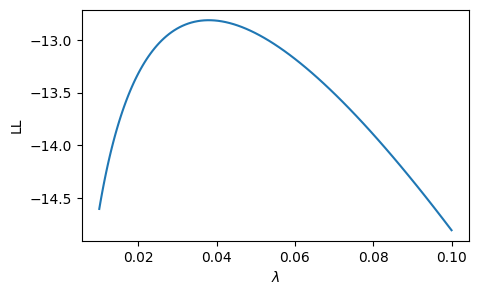

In [510]:
# Visualize how the LL changes as lambda varies
xval = np.geomspace(0.01, 0.1, 100)

yval = [np.sum(exp_log_pdf(lam, points)) + np.sum(exp_log_sf(lam, right_censored_points)) for lam in xval]
xdx = np.argmax(yval)
print(f"The value of lambda that maximizes the log likelihood is {xval[xdx]:.5f}")
print("Note this value is not exact due to usage of np.argmax")

plt.figure(figsize=(5,3))
plt.plot(xval, yval)
plt.xlabel(r"$\lambda$")
plt.ylabel("LL")

Example: Weibull Distribution with point and right-censored data
---

In [511]:
points = np.array([17, 5, 12])
right_censored_points = np.array([20, 25])

weibull_pdf = lambda t, a, b: (b/a) * (t-a)**(b-1) * np.exp(-(t/a)**b)
weibull_log_pdf = lambda t, a, b: np.log(b/a) + (b-1)*np.log(t/a) - (t/a)**b

weibull_sf = lambda t, a, b: np.exp(-(t/a)**b)
weibull_log_sf = lambda t, a, b: -(t/a)**b

alpha = 15
beta = 2

LL = np.sum(weibull_log_pdf(points, alpha, beta))
LL += np.sum(weibull_log_sf(right_censored_points, alpha, beta))
LL

-13.832412869766218

In [512]:
from mpl_toolkits.mplot3d import Axes3D

alpha_arr = np.linspace(15, 45, 50)
beta_arr = np.linspace(0.8, 3, 50)

A, B = np.meshgrid(alpha_arr, beta_arr)

LL = np.empty((len(alpha_arr), len(beta_arr)))
for i, alpha in enumerate(alpha_arr):
    for j, beta in enumerate(beta_arr):
        LL[i][j] = np.sum(weibull_log_pdf(points, alpha, beta))
        LL[i][j] += np.sum(weibull_log_sf(right_censored_points, alpha, beta))

LL_max = LL.max()
print(LL_max)
idx = np.where(LL==LL_max)

alpha_fit = alpha_arr[idx[0][0]]
beta_fit = beta_arr[idx[1][0]]
print(alpha_fit, beta_fit)

-12.482579778877799
22.95918367346939 1.563265306122449


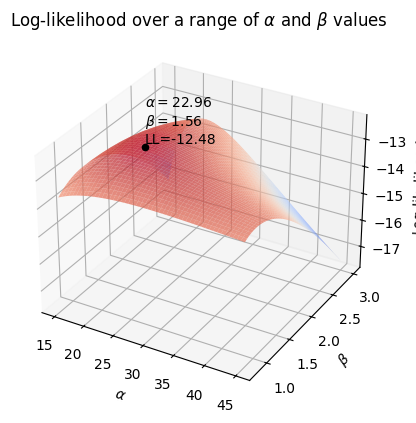

In [513]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, LL.transpose(), cmap="coolwarm", linewidth=1, antialiased=True, alpha=0.7, zorder=0)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('Log-likelihood')
ax.scatter([alpha_fit], [beta_fit], [LL_max], color='k', zorder=1)
text_string = str(r'$\alpha=$' + str(round(alpha_fit, 2)) + '\n' + r'$\beta=$' + str(round(beta_fit, 2)) + '\nLL=' + str(round(LL_max, 2)))
ax.text(x=alpha_fit, y=beta_fit, z=LL_max+0.1, s=text_string)
ax.computed_zorder = False
plt.title(r'Log-likelihood over a range of $\alpha$ and $\beta$ values')
plt.show()

MLE & Tolerance Bound
---

Fit distribution via MLE, then bootstrap to calculate tolerance bound

JohnsonSU pdf, standardized form:
\begin{split}
f(x, a, b) = \frac{b}{\sqrt{x^2 + 1}}
                     \phi(a + b \log(x + \sqrt{x^2 + 1}))
\end{split}

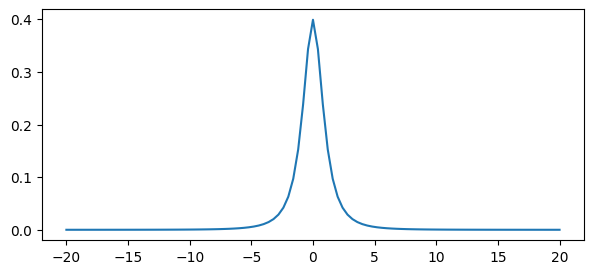

In [514]:
x = np.linspace(-20,20,101)
alpha = 0
beta = 1
jsu_pdf = scipy.stats.johnsonsu.pdf(x, alpha, beta)
plt.figure(figsize=(7,3))
plt.plot(x, jsu_pdf)

In [515]:
import yfinance as yf
import datetime

TODAY = datetime.date.today()

ONE_YEAR_AGO = TODAY - datetime.timedelta(days=365)
TWO_YEARS_AGO = TODAY - 2*datetime.timedelta(days=365)

ONE_YEAR_AGO_STR = ONE_YEAR_AGO.strftime("%Y-%m-%d")
TWO_YEAR_AGO_STR = TWO_YEARS_AGO.strftime("%Y-%m-%d")

INDICES2SHOW = ["SPY", "QQQ"]  # ["^GSPC", "^DJI", "^IXIC", "^VIX", "^VVIX"]
data = yf.download(
    tickers=INDICES2SHOW,
    start=ONE_YEAR_AGO_STR,
    group_by="ticker"
)
SPYdata = data.SPY
SPYclose = SPYdata.Close

/var/folders/k_/hnb1_vkj1_l_shldt3pblqrr0000gn/T/ipykernel_79108/2904053361.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  2 of 2 completed


In [516]:
SPYlogret = np.log(SPYclose) - np.log(SPYclose.shift(1))
SPYlogret.dropna(inplace=True)
SPYlogret100 = SPYlogret * 100

In [517]:
def nll_johnsonsu(params, data):
    return -np.sum(scipy.stats.johnsonsu.logpdf(data, *params))

def nll_normal(params, data):
    return -np.sum(scipy.stats.norm.logpdf(data, *params))

nll_johnsonsu([1,1], SPYlogret100), nll_normal([0,1], SPYlogret100)

(504.8869528396551, 419.78404425550855)

In [518]:
cons = [
    {'type': 'ineq', 'fun': lambda x: x[1]-0.0001},
    {'type': 'ineq', 'fun': lambda x: x[3]-0.0001},  # that little thing a the end is needed to avoid a divide by zero / singular matrix error...
]
sol = scipy.optimize.minimize(nll_johnsonsu, x0=[0, 1, SPYlogret100.mean(), 1], method="SLSQP", args=(SPYlogret100), constraints=cons)
# sol = scipy.optimize.minimize(nll_johnsonsu, x0=[0, 1], args=(SPYlogret100), constraints=cons)
sol

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 340.1858147519144
           x: [ 2.336e-01  1.006e+00  2.947e-01  6.448e-01]
         nit: 12
         jac: [-1.129e-03 -6.962e-03  7.122e-03 -7.706e-04]
        nfev: 68
        njev: 12
 multipliers: [ 0.000e+00  0.000e+00]

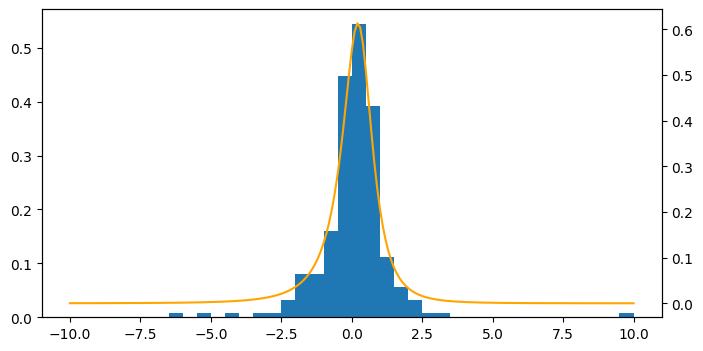

In [519]:
xvals1 = np.linspace(-10, 10, 41)
xvals2 = np.linspace(-10, 10, 201)
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax1.hist(SPYlogret100, bins=xvals1, density=True)
ax2.plot(xvals2, scipy.stats.johnsonsu.pdf(xvals2, *sol.x), color="orange")
#ax2.plot(xvals2, scipy.stats.norm.pdf(xvals2, *sol.x), color="orange")
#ax2.set_ylim([0, 42])

In [527]:
# convention: (Coverage)% / (Confidence)%
ll_mle = -1 * sol.fun  # solution use negative LL
CONFIDENCE = 0.99
sidedness = 1
alpha_eff = 2*(1-CONFIDENCE)/sidedness
chi2_crit = scipy.stats.chi2.ppf(1-alpha_eff, df=1)  # confidence is used to decrement log likelihood
ll_target = ll_mle - chi2_crit/2  # divided by 2 - based on likelihood ratio stat
ll_mle, ll_target

(-340.1858147519144, -342.89176196744154)

In [535]:
COVERAGE = 0.99

def jsu_ll(params):
    return np.sum(scipy.stats.johnsonsu.logpdf(SPYlogret100, *params))

def jsu_ll_target(params):
    return ll_target - jsu_ll(params)

def jsu_nU(params):
    return -1 * scipy.stats.johnsonsu.ppf(COVERAGE, *params)  # the upper bound comes from coverage

def normal_ll(params):
    return np.sum(scipy.stats.norm.logpdf(SPYlogret100, *params))

def normal_ll_target(params):
    return ll_target - normal_ll(params)

def normal_nU(params):
    return -1 * scipy.stats.norm.ppf(COVERAGE, *params)  # the upper bound comes from coverage

cons = [
    {"type": "eq", "fun": jsu_ll_target},
    {'type': 'ineq', 'fun': lambda x: x[1]-0.0001},
    {'type': 'ineq', 'fun': lambda x: x[3]-0.0001},  # that little thing a the end is needed to avoid a divide by zero / singular matrix error...
]
wtf = scipy.optimize.minimize(jsu_nU, x0=sol.x, method="trust-constr", constraints=cons, options={"maxiter": 20000})
wtf

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -4.328689890789986
                 x: [ 2.778e-02  8.378e-01  1.677e-01  5.377e-01]
               nit: 2916
              nfev: 17525
              njev: 3505
              nhev: 0
          cg_niter: 7549
      cg_stop_cond: 4
              grad: [ 5.008e+00  1.374e+01 -1.000e+00 -7.738e+00]
   lagrangian_grad: [ 1.562e-06 -1.776e-07  5.333e-07  6.269e-07]
            constr: [array([ 0.000e+00]), array([ 8.377e-01]), array([ 5.376e-01])]
               jac: [array([[-1.277e+01, -3.503e+01,  2.550e+00,
                             1.973e+01]]), array([[ 0.000e+00,  1.000e+00,  0.000e+00,
                             0.000e+00]]), array([[ 0.000e+00,  0.000e+00,  0.000e+00,
                             1.000e+00]])]
       constr_nfev: [17525, 17525, 17525]
       constr_njev: [0, 0, 0]
       constr_nhev: [0, 0, 0]
                 v: [array([ 3.922e-01])

In [536]:
scipy.stats.johnsonsu.ppf(COVERAGE, *wtf.x), scipy.stats.johnsonsu.ppf(COVERAGE, *sol.x), jsu_ll_target(wtf.x)
#scipy.stats.norm.ppf(COVERAGE, *wtf.x), scipy.stats.norm.ppf(COVERAGE, *sol.x), jsu_ll_target(wtf.x)

(4.328689890789986, 2.8377418006189314, 0.0)

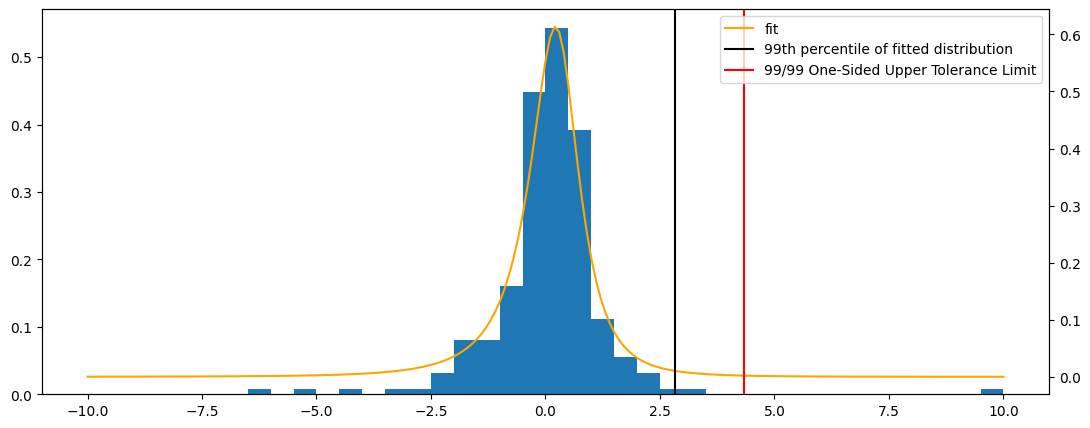

In [537]:
xvals1 = np.linspace(-10, 10, 41)
xvals2 = np.linspace(-10, 10, 201)
fig, ax1 = plt.subplots(figsize=(13,5))
ax2 = ax1.twinx()
ax1.hist(SPYlogret100, bins=xvals1, density=True, label="data")
ax2.plot(xvals2, scipy.stats.johnsonsu.pdf(xvals2, *sol.x), color="orange", label="fit")
ax2.axvline(scipy.stats.johnsonsu.ppf(COVERAGE, *sol.x), color="black", label=f"{COVERAGE*100:.0f}th percentile of fitted distribution")
ax2.axvline(scipy.stats.johnsonsu.ppf(COVERAGE, *wtf.x), color="red", label=f"{COVERAGE*100:.0f}/{CONFIDENCE*100:.0f} One-Sided Upper Tolerance Limit")
ax2.legend(loc="upper right")